In [1]:
#%% Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
from os.path import join as pjoin
from scipy.stats import zscore


import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from spks.utils import alpha_function
from ephys.utils_analysis import compute_mean_sem
from ephys.viz import plot_psth

pd.set_option('display.max_columns', 100)

plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'svg'
%matplotlib widget
%load_ext autoreload
%autoreload 2



#%% Load data
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = '/Users/gabriel/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

trial_ts = trial_ts[
    trial_ts['stationary_stims'].apply(lambda x: len(x) > 0) &
    trial_ts['movement_stims'].apply(lambda x: len(x) > 0) &
    trial_ts['center_port_entries'].apply(lambda x: len(x) > 0)
].copy()

In [2]:
stim_lists = trial_ts.stationary_stims.tolist()
n_stims = 4

tmp = [
    np.array([stims[i] for stims in stim_lists if len(stims) > i])
    for i in range(n_stims)
]

first_stim, second_stim, third_stim, fourth_stim = tmp

first_movement_stim = np.array([stims[0] for stims in trial_ts.movement_stims.tolist()])

### Compare PSTHs no normalization

In [3]:
binwidth_ms = 25
pre_seconds = binwidth_ms/1000
post_seconds = 0.15 + pre_seconds

t_decay = 0.025
t_rise = 0.001
decay = t_decay / (binwidth_ms/1000)
kern = alpha_function(int(decay * 15), t_rise=t_rise, t_decay=decay, srate=1./(binwidth_ms/1000))

# # Now calculate all PSTHs with original timing
# all_stims = [first_stim, second_stim, third_stim, fourth_stim, first_movement_stim]
# all_peths = []
# timebins = None

# for stim_times in all_stims:
#     peth, current_timebins, event_index = population_peth(
#         all_spike_times=spike_times_per_unit,
#         alignment_times=stim_times,
#         pre_seconds=pre_seconds,
#         post_seconds=post_seconds,
#         binwidth_ms=binwidth_ms,
#         kernel=kern,
#         pad=0
#     )
#     all_peths.append(peth)
#     if timebins is None:
#         timebins = current_timebins

# # Determine sorting order based on first stimulus 
# first_peth = all_peths[0]
# trial_avg_psth_first = np.mean(first_peth, axis=1)
# peak_idx_first = np.argmax(trial_avg_psth_first, axis=1)
# peak_idx_sort_first = np.argsort(peak_idx_first)

# # Create subplot grid
# from matplotlib.colors import TwoSlopeNorm
# all_norms = [np.mean(p, axis=1) for p in all_peths]
# global_min = min(np.min(n) for n in all_norms)
# global_max = max(np.max(n) for n in all_norms)
# norm = TwoSlopeNorm(vmin=-global_min, vcenter=0, vmax=30)
# fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True, constrained_layout=True)

# for i, peth in enumerate(all_peths):
#     ax = axes[i]
    
#     # Average trials and z-score using baseline
#     trial_avg_psth = np.mean(peth, axis=1)
    
#     # Apply the sort order from the first stimulus
#     sorted_trial_avg_psth = trial_avg_psth[peak_idx_sort_first]
    
#     im = ax.imshow(sorted_trial_avg_psth, aspect='auto', cmap='binary', vmin=0, vmax=60)#norm=norm)
#     n = i + 1
#     if 10 <= n % 100 <= 20:
#         suffix = 'th'
#     else:
#         suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
#     if i < len(all_peths)-1:
#         ax.set_title(f'{n}{suffix} flash')
#     else:
#         ax.set_title(f'1st running flash')
#     ax.set_xlabel('time from flash onset (ms)')
#     xloc = np.array([0, 5])
#     ax.set_xticks(xloc, xloc * binwidth_ms/1000)
#     if i == 0:
#         ax.set_ylabel('units sorted by first stim peak')

# fig.colorbar(im, ax=axes.ravel().tolist(), label='sp/s')
# plt.show()

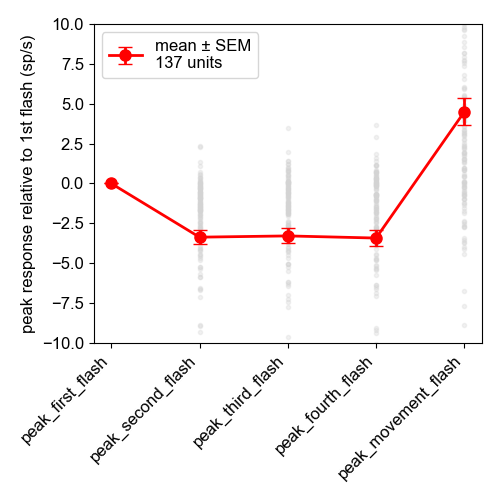

In [4]:
# Compute peak responses 0.4–1.0 s after each flash, for each unit
stimuli = [first_stim, second_stim, third_stim, fourth_stim, first_movement_stim]
peak_responses = []
stim_window_start = 0.04
stim_window_end = 0.1

for stim_times in stimuli:
    peth, tb, _ = population_peth(
        all_spike_times=spike_times_per_unit,
        alignment_times=stim_times,
        pre_seconds=pre_seconds,
        post_seconds=post_seconds,
        binwidth_ms=binwidth_ms,
        kernel=kern,
        pad=0
    )
    # select timebins between 0.4 and 1.0 s
    stimulus_window_bool = (tb[:-1] >= stim_window_start) & (tb[:-1] <= stim_window_end)
    peak_response = np.max(np.mean(peth[:, :, stimulus_window_bool], axis=1), axis=1)
    peak_responses.append(peak_response)

# stack into (n_units, 5) and wrap in a DataFrame
peak_matrix = np.stack(peak_responses, axis=1)
colnames = ['peak_first_flash',
            'peak_second_flash',
            'peak_third_flash',
            'peak_fourth_flash',
            'peak_movement_flash']
peak_df = pd.DataFrame(peak_matrix, columns=colnames)

# Plot each unit’s peak responses across the five stimuli
peak_subtracted_df = peak_df.subtract(peak_df['peak_first_flash'], axis=0)
stimuli = peak_subtracted_df.columns
x = np.arange(len(stimuli))

fig, ax = plt.subplots(figsize=(5, 5))

# Plot individual units as dots
for vals in peak_subtracted_df.values:
    ax.plot(x, vals, 'o', color='lightgray', alpha=0.3, markersize=3)

# Plot mean ± SEM
means = peak_subtracted_df.mean()
sems = peak_subtracted_df.sem()
ax.errorbar(x, means, yerr=sems, fmt='o-', color='red', linewidth=2, 
           markersize=8, capsize=5, label=f'mean ± SEM\n{len(peak_subtracted_df)} units')

ax.set_xticks(x)
ax.set_xticklabels(stimuli, rotation=45, ha='right')
ax.set_ylabel('peak response relative to 1st flash (sp/s)')
ax.legend()
plt.ylim([-10, 10])
plt.tight_layout()
plt.show()

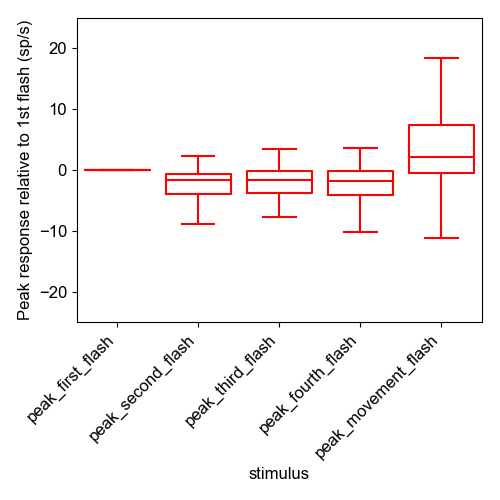

In [5]:
melt_peak = peak_subtracted_df.melt(var_name='stimulus', value_name='response')
plt.figure(figsize=(5, 5))
sns.boxplot(data=melt_peak, x='stimulus', y='response', color='red', showfliers=False, fill=False)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Peak response relative to 1st flash (sp/s)')
plt.ylim([-25, 25])
plt.tight_layout()
plt.show()

Left response trials: 178
Right response trials: 203


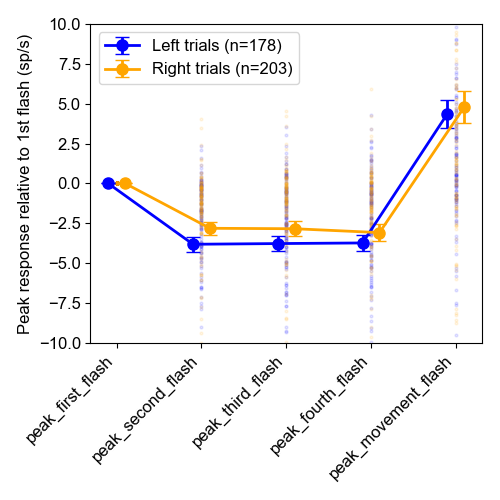

In [6]:
# Split trials by response side
left_trials = trial_ts[trial_ts['response_side'] == 0].copy()
right_trials = trial_ts[trial_ts['response_side'] == 1].copy()

print(f"Left response trials: {len(left_trials)}")
print(f"Right response trials: {len(right_trials)}")

# Extract stimulus times for each response side
def extract_stims_by_side(trials_df, n_stims=4):
    stim_lists = trials_df.stationary_stims.tolist()
    stims = [
        np.array([stims[i] for stims in stim_lists if len(stims) > i])
        for i in range(n_stims)
    ]
    movement_stim = np.array([stims[0] for stims in trials_df.movement_stims.tolist()])
    return stims + [movement_stim]

left_stims = extract_stims_by_side(left_trials)
right_stims = extract_stims_by_side(right_trials)

# Calculate peak responses for left and right trials separately
def calculate_peak_responses(stim_list, label):
    peak_responses = []
    for stim_times in stim_list:
        peth, tb, _ = population_peth(
            all_spike_times=spike_times_per_unit,
            alignment_times=stim_times,
            pre_seconds=pre_seconds,
            post_seconds=post_seconds,
            binwidth_ms=binwidth_ms,
            kernel=kern,
            pad=0
        )
        # select timebins between 0.04 and 0.1 s
        stimulus_window_bool = (tb[:-1] >= stim_window_start) & (tb[:-1] <= stim_window_end)
        peak_response = np.max(np.mean(peth[:, :, stimulus_window_bool], axis=1), axis=1)
        peak_responses.append(peak_response)
    return peak_responses

# Get peak responses for each side
left_peak_responses = calculate_peak_responses(left_stims, "left")
right_peak_responses = calculate_peak_responses(right_stims, "right")

# Create DataFrames
colnames = ['peak_first_flash', 'peak_second_flash', 'peak_third_flash', 
           'peak_fourth_flash', 'peak_movement_flash']

left_peak_matrix = np.stack(left_peak_responses, axis=1)
right_peak_matrix = np.stack(right_peak_responses, axis=1)

left_peak_df = pd.DataFrame(left_peak_matrix, columns=colnames)
right_peak_df = pd.DataFrame(right_peak_matrix, columns=colnames)

# Subtract first flash response for each side
left_peak_subtracted_df = left_peak_df.subtract(left_peak_df['peak_first_flash'], axis=0)
right_peak_subtracted_df = right_peak_df.subtract(right_peak_df['peak_first_flash'], axis=0)

# Plot comparison
stimuli = left_peak_subtracted_df.columns
x = np.arange(len(stimuli))

fig, ax = plt.subplots(figsize=(5, 5))

# Plot individual units as dots for both sides
for vals in left_peak_subtracted_df.values:
    ax.plot(x, vals, 'o', color='blue', alpha=0.1, markersize=2)
for vals in right_peak_subtracted_df.values:
    ax.plot(x, vals, 'o', color='orange', alpha=0.1, markersize=2)

# Plot means ± SEM for both sides
left_means = left_peak_subtracted_df.mean()
left_sems = left_peak_subtracted_df.sem()
right_means = right_peak_subtracted_df.mean()
right_sems = right_peak_subtracted_df.sem()

ax.errorbar(x - 0.1, left_means, yerr=left_sems, fmt='o-', color='blue', linewidth=2, 
           markersize=8, capsize=5, label=f'Left trials (n={len(left_trials)})')
ax.errorbar(x + 0.1, right_means, yerr=right_sems, fmt='o-', color='orange', linewidth=2, 
           markersize=8, capsize=5, label=f'Right trials (n={len(right_trials)})')

ax.set_xticks(x)
ax.set_xticklabels(stimuli, rotation=45, ha='right')
ax.set_ylabel('Peak response relative to 1st flash (sp/s)')
ax.set_ylim([-10, 10])
ax.legend()
plt.tight_layout()
plt.show()

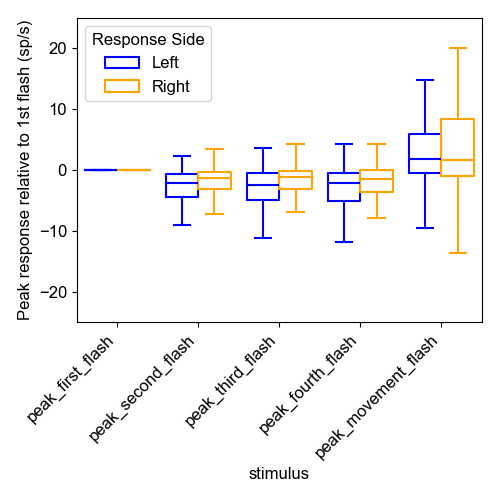

In [7]:
# Melt the DataFrames for plotting
left_melted = left_peak_subtracted_df.melt(var_name='stimulus', value_name='response')
left_melted['side'] = 'Left'

right_melted = right_peak_subtracted_df.melt(var_name='stimulus', value_name='response')
right_melted['side'] = 'Right'

combined_df = pd.concat([left_melted, right_melted], ignore_index=True)

# Create boxplot
plt.figure(figsize=(5, 5))
sns.boxplot(data=combined_df, x='stimulus', y='response', hue='side', palette=['blue', 'orange'], showfliers=False, fill=False)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Peak response relative to 1st flash (sp/s)')
plt.ylim([-25, 25])
plt.legend(title='Response Side')
plt.tight_layout()
plt.show()